In [1]:
import pandas as pd
df = pd.read_csv("./clean_data_by_day.csv")
df.head()

,Timestamp,Date,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325289600,2011-12-31,4.39,4.58,4.39,4.58,23.829470,106.330084,4.471603
1,1325376000,2012-01-01,4.58,5.00,4.58,5.00,7.200667,35.259720,4.806667
2,1325462400,2012-01-02,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
3,1325548800,2012-01-03,5.32,5.32,5.14,5.29,11.004660,58.100651,5.252500
4,1325635200,2012-01-04,4.93,5.57,4.93,5.57,11.914807,63.119577,5.208159


In [2]:
closedf = df[(df['Date']>='2020-01-01') & (df['Date']<'2021-01-01')][['Date','Close']]
close_stock = closedf.copy()
closedf.head()

,Date,Close
2920,2020-01-01,7178.68
2921,2020-01-02,6950.56
2922,2020-01-03,7338.91
2923,2020-01-04,7344.48
2924,2020-01-05,7356.70


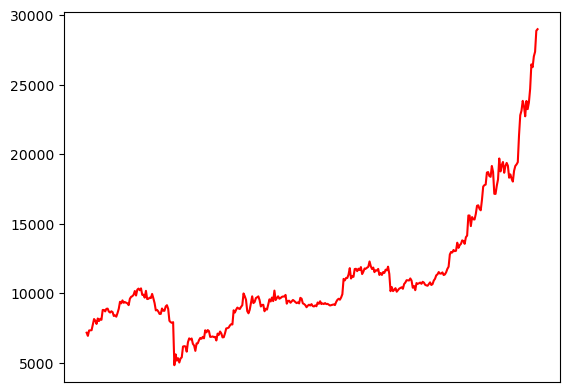

<Figure size 640x480 with 0 Axes>

In [3]:
# Import the necessaries libraries
import matplotlib.pyplot as plt
plt.plot(closedf.Date, closedf.Close, 'r')
plt.xticks([])
plt.figure()
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(366, 1)


In [5]:
training_size=int(len(closedf)*0.60)
train_data,test_data=closedf[0:training_size],closedf[training_size:len(closedf)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (147, 1)


In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
X_train, Y_train = create_dataset(train_data, 15)
X_test, Y_test = create_dataset(test_data, 15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test", Y_test.shape)

X_train:  (203, 15, 1)
Y_train:  (203,)
X_test:  (131, 15, 1)
Y_test (131,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=300,batch_size=25,verbose=1)

Epoch 1/300
9/9 [==============================] - 3s 78ms/step - loss: 0.0110 - val_loss: 0.0748
Epoch 2/300
9/9 [==============================] - 0s 26ms/step - loss: 0.0045 - val_loss: 0.0473
Epoch 3/300
9/9 [==============================] - 0s 24ms/step - loss: 0.0015 - val_loss: 0.0291
Epoch 4/300
9/9 [==============================] - 0s 23ms/step - loss: 0.0010 - val_loss: 0.0220
Epoch 5/300
9/9 [==============================] - ETA: 0s - loss: 9.4919e-04

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(Y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(Y_test.reshape(-1,1)) 

In [ ]:
look_back=15
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

plotdf.to_csv('./predicted_data.csv', index=None, encoding="utf_8_sig")

plt.plot(plotdf['date'], plotdf['original_close'], 'red', label='Real Price')
plt.plot(plotdf['date'], plotdf['train_predicted_close'], 'blue', label='Predicted Price (training set)')
plt.plot(plotdf['date'], plotdf['test_predicted_close'], 'green', label='Predicted Price (testing set)')

plt.title('Bitcoin Close Price Prediction of 2020')
plt.legend(loc=0)

plt.xticks([])
plt.figure()
plt.show()